Credit Default.

Ongoing model for 'bad' and 'good' credit applicants clasification.

Dataset downloaded from Kaggle:

https://www.kaggle.com/c/home-credit-default-risk/data?select=application_train.csv

In [4]:
#Import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


To do list:


1.   Add Payment/income ratio Feature
2.   Choose best replacement to NaN's instead of removing them
3. Look for the target frequency
4. Find a way to adjust the clasification threshold
5. Normalize test data too
6. Try setting ROC_AUC as scoring function instead of recall at cross validation
7. To Check how much the positive class is undersampled


In [6]:
# Import precleaned data (Only some features removed from excel)
from google.colab import files
uploaded = files.upload()

Saving application_train cleaned.csv to application_train cleaned.csv


In [8]:
# Dataset is now stored as a Pandas Dataframe
import io
df2 = pd.read_csv(io.BytesIO(uploaded['application_train cleaned.csv']))

In [9]:
# Remove more features, Ext_source_1 because has more than 60% NaN's values and the rest due to are not significant according to the feature relevance chart showed later.
df2 = df2.drop(['EXT_SOURCE_1','OCCUPATION_TYPE', 'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1)

In [10]:
df2

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,2,Business Entity Type 3,0.262949,0.139376,-1134.0,2.0,-3648.0,-2120,1
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Higher education,Married,House / apartment,-16765,-1188,1,School,0.622246,NaN,-828.0,1.0,-1186.0,-291,1
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,2,Government,0.555912,0.729567,-815.0,0.0,-4260.0,-2531,1
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Secondary / secondary special,Civil marriage,House / apartment,-19005,-3039,2,Business Entity Type 3,0.650442,NaN,-617.0,2.0,-9833.0,-2437,1
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Secondary / secondary special,Single / not married,House / apartment,-19932,-3038,2,Religion,0.322738,NaN,-1106.0,0.0,-4311.0,-3458,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Secondary / secondary special,Separated,With parents,-9327,-236,1,Services,0.681632,NaN,-273.0,0.0,-8456.0,-1982,1
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Secondary / secondary special,Widow,House / apartment,-20775,365243,2,XNA,0.115992,NaN,0.0,0.0,-4388.0,-4090,1
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Higher education,Separated,House / apartment,-14966,-7921,3,School,0.535722,0.218859,-1909.0,6.0,-6737.0,-5150,1
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Secondary / secondary special,Married,House / apartment,-11961,-4786,2,Business Entity Type 1,0.514163,0.661024,-322.0,0.0,-2562.0,-931,1


In [11]:
# Create dummies manually from binary features except the target one.
df2 = df2.replace({'Cash loans': 0, 'Revolving loans': 1, 'F': 0, 'M': 1, 'Y': 1, 'N':0})
# Remove all the NaN's values.
df2NoNan = df2.dropna()

In [12]:
# Previous dataset with empty cells (NaN's)
df2.isna().sum().head(40)

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
REGION_RATING_CLIENT_W_CITY        0
ORGANIZATION_TYPE                  0
EXT_SOURCE_2                     660
EXT_SOURCE_3                   60965
DAYS_LAST_PHONE_CHANGE             1
OBS_30_CNT_SOCIAL_CIRCLE        1021
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_CONT_MOBILE                   0
dtype: int64

In [13]:
# Once NaN's are removed
df2NoNan.isna().sum().head(40)

SK_ID_CURR                     0
TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
REGION_RATING_CLIENT_W_CITY    0
ORGANIZATION_TYPE              0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
DAYS_LAST_PHONE_CHANGE         0
OBS_30_CNT_SOCIAL_CIRCLE       0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_CONT_MOBILE               0
dtype: int64

In [14]:
# Frequency of target classes
counter = df2NoNan['TARGET'].value_counts()
print(counter)

0    226077
1     19071
Name: TARGET, dtype: int64


In [15]:
# Remove a couple of 'error' values detected by printing unique values 
df2NoNan = df2NoNan[df2NoNan.CODE_GENDER != 'XNA']

In [16]:
df2NoNan

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,2,Business Entity Type 3,0.262949,0.139376,-1134.0,2.0,-3648.0,-2120,1
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,2,Government,0.555912,0.729567,-815.0,0.0,-4260.0,-2531,1
5,100008,0,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,Secondary / secondary special,Married,House / apartment,-16941,-1588,2,Other,0.354225,0.621226,-2536.0,0.0,-4970.0,-477,1
6,100009,0,0,0,1,1,1,171000.0,1560726.0,41301.0,1395000.0,Higher education,Married,House / apartment,-13778,-3130,2,Business Entity Type 3,0.724000,0.492060,-1562.0,1.0,-1213.0,-619,1
7,100010,0,0,1,1,1,0,360000.0,1530000.0,42075.0,1530000.0,Higher education,Married,House / apartment,-18850,-449,3,Other,0.714279,0.540654,-1070.0,2.0,-4597.0,-2379,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307503,456247,0,0,0,0,1,0,112500.0,345510.0,17770.5,247500.0,Higher education,Single / not married,House / apartment,-11870,-399,2,Bank,0.501221,0.609276,-2315.0,9.0,-675.0,-3936,1
307505,456249,0,0,0,0,1,0,112500.0,225000.0,22050.0,225000.0,Secondary / secondary special,Single / not married,House / apartment,-24384,365243,2,XNA,0.346391,0.742182,0.0,0.0,-7369.0,-2357,1
307508,456253,0,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,Higher education,Separated,House / apartment,-14966,-7921,3,School,0.535722,0.218859,-1909.0,6.0,-6737.0,-5150,1
307509,456254,1,0,0,0,1,0,171000.0,370107.0,20205.0,319500.0,Secondary / secondary special,Married,House / apartment,-11961,-4786,2,Business Entity Type 1,0.514163,0.661024,-322.0,0.0,-2562.0,-931,1


In [17]:
# Dummies generation using pandas for multi clase features
dfDummies = pd.get_dummies(df2NoNan[["NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS"]])
# The following features should be converted to dummies as well: "ORGANIZATION_TYPE", "OCCUPATION_TYPE", "NAME_HOUSING_TYPE"
# But they are not too significant, I'll give a try without them

In [18]:
dfDummies

,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,1,0
5,0,0,0,0,1,0,1,0,0,0
6,0,1,0,0,0,0,1,0,0,0
7,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
307503,0,1,0,0,0,0,0,0,1,0
307505,0,0,0,0,1,0,0,0,1,0
307508,0,1,0,0,0,0,0,1,0,0
307509,0,0,0,0,1,0,1,0,0,0


In [19]:
# Remove the original features from dummies were obtained and the others which will not be considered by now.
df2NoNan = df2NoNan.drop(['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE', 'SK_ID_CURR'], axis = 1)

In [20]:
# Join the dummies with the main dataframe
FinalDf = df2NoNan.join(dfDummies)

In [21]:
# Convert feature string format to integer
FinalDf['CODE_GENDER'] = FinalDf['CODE_GENDER'].astype(int)

In [22]:
FinalDf

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,-9461,-637,2,0.262949,0.139376,-1134.0,2.0,-3648.0,-2120,1,0,0,0,0,1,0,0,0,1,0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,-19046,-225,2,0.555912,0.729567,-815.0,0.0,-4260.0,-2531,1,0,0,0,0,1,0,0,0,1,0
5,0,0,1,0,1,0,99000.0,490495.5,27517.5,454500.0,-16941,-1588,2,0.354225,0.621226,-2536.0,0.0,-4970.0,-477,1,0,0,0,0,1,0,1,0,0,0
6,0,0,0,1,1,1,171000.0,1560726.0,41301.0,1395000.0,-13778,-3130,2,0.724000,0.492060,-1562.0,1.0,-1213.0,-619,1,0,1,0,0,0,0,1,0,0,0
7,0,0,1,1,1,0,360000.0,1530000.0,42075.0,1530000.0,-18850,-449,3,0.714279,0.540654,-1070.0,2.0,-4597.0,-2379,1,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307503,0,0,0,0,1,0,112500.0,345510.0,17770.5,247500.0,-11870,-399,2,0.501221,0.609276,-2315.0,9.0,-675.0,-3936,1,0,1,0,0,0,0,0,0,1,0
307505,0,0,0,0,1,0,112500.0,225000.0,22050.0,225000.0,-24384,365243,2,0.346391,0.742182,0.0,0.0,-7369.0,-2357,1,0,0,0,0,1,0,0,0,1,0
307508,0,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,-14966,-7921,3,0.535722,0.218859,-1909.0,6.0,-6737.0,-5150,1,0,1,0,0,0,0,0,1,0,0
307509,1,0,0,0,1,0,171000.0,370107.0,20205.0,319500.0,-11961,-4786,2,0.514163,0.661024,-322.0,0.0,-2562.0,-931,1,0,0,0,0,1,0,1,0,0,0


REMOVE OUTLIERS 

Is recommended to remove values for each feature that is over or under three standart deviations from mean.

It could be done into a function with a loop but let's do it seperately for the sake of simplicity.

In [23]:
from scipy import stats
FinalDf['DAYS_LAST_PHONE_CHANGE'] = FinalDf['DAYS_LAST_PHONE_CHANGE'][(np.abs(stats.zscore(FinalDf['DAYS_LAST_PHONE_CHANGE'])) < 3)]
FinalDf = FinalDf.dropna()

In [24]:
FinalDf['AMT_INCOME_TOTAL'] = FinalDf['AMT_INCOME_TOTAL'][(np.abs(stats.zscore(FinalDf['AMT_INCOME_TOTAL'])) < 3)]
FinalDf = FinalDf.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
FinalDf['CNT_CHILDREN'] = FinalDf['CNT_CHILDREN'][(np.abs(stats.zscore(FinalDf['CNT_CHILDREN'])) < 3)]
FinalDf = FinalDf.dropna()

In [26]:
FinalDf['AMT_ANNUITY'] = FinalDf['AMT_ANNUITY'][(np.abs(stats.zscore(FinalDf['AMT_ANNUITY'])) < 3)]
FinalDf = FinalDf.dropna()

In [27]:
FinalDf['AMT_GOODS_PRICE'] = FinalDf['AMT_GOODS_PRICE'][(np.abs(stats.zscore(FinalDf['AMT_GOODS_PRICE'])) < 3)]
FinalDf = FinalDf.dropna()

In [28]:
FinalDf['DAYS_EMPLOYED'] = FinalDf['DAYS_EMPLOYED'][(np.abs(stats.zscore(FinalDf['DAYS_EMPLOYED'])) < 3)]
FinalDf = FinalDf.dropna()

In [29]:
FinalDf

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
0,1,0,1,0,1,0.0,202500.0,406597.5,24700.5,351000.0,-9461,-637,2,0.262949,0.139376,-1134.0,2.0,-3648.0,-2120,1,0,0,0,0,1,0,0,0,1,0
2,0,1,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,-19046,-225,2,0.555912,0.729567,-815.0,0.0,-4260.0,-2531,1,0,0,0,0,1,0,0,0,1,0
5,0,0,1,0,1,0.0,99000.0,490495.5,27517.5,454500.0,-16941,-1588,2,0.354225,0.621226,-2536.0,0.0,-4970.0,-477,1,0,0,0,0,1,0,1,0,0,0
6,0,0,0,1,1,1.0,171000.0,1560726.0,41301.0,1395000.0,-13778,-3130,2,0.724000,0.492060,-1562.0,1.0,-1213.0,-619,1,0,1,0,0,0,0,1,0,0,0
7,0,0,1,1,1,0.0,360000.0,1530000.0,42075.0,1530000.0,-18850,-449,3,0.714279,0.540654,-1070.0,2.0,-4597.0,-2379,1,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307503,0,0,0,0,1,0.0,112500.0,345510.0,17770.5,247500.0,-11870,-399,2,0.501221,0.609276,-2315.0,9.0,-675.0,-3936,1,0,1,0,0,0,0,0,0,1,0
307505,0,0,0,0,1,0.0,112500.0,225000.0,22050.0,225000.0,-24384,365243,2,0.346391,0.742182,0.0,0.0,-7369.0,-2357,1,0,0,0,0,1,0,0,0,1,0
307508,0,0,0,0,1,0.0,153000.0,677664.0,29979.0,585000.0,-14966,-7921,3,0.535722,0.218859,-1909.0,6.0,-6737.0,-5150,1,0,1,0,0,0,0,0,1,0,0
307509,1,0,0,0,1,0.0,171000.0,370107.0,20205.0,319500.0,-11961,-4786,2,0.514163,0.661024,-322.0,0.0,-2562.0,-931,1,0,0,0,0,1,0,1,0,0,0


In [30]:
# Function to confirm if outliers were removed

col_data = FinalDf['CNT_CHILDREN']
#(['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'])
def find_anomalies(data):
    #define a list to accumlate anomalies
        #lists_df = []
        anomalies = [] 
        # Set upper and lower limit to 3 standard deviation
        #for col in col_data:
        random_data_std = np.std(col_data)
        random_data_mean = np.mean(col_data)
        anomaly_cut_off = random_data_std * 3
        
        lower_limit  = random_data_mean - anomaly_cut_off 
        upper_limit = random_data_mean + anomaly_cut_off
        print(lower_limit)
        # Generate outliers
        for outlier in col_data:
            if outlier > upper_limit or outlier < lower_limit:
                anomalies.append(outlier)
        #lists_df.append(anomalies)
        return anomalies
find_anomalies(col_data)

-1.5540021291415655


[]

In [31]:
noutliers = find_anomalies(col_data)
print (noutliers)

-1.5540021291415655
[]


In [32]:
len(noutliers)

0

In [33]:
# Check if everything is okey with the dataframe description
FinalDf.describe()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow
count,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,2.361220e+05,236122.000000,2.361220e+05,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000,236122.000000
mean,0.078451,0.091182,0.333218,0.344182,0.691210,0.384670,167063.765254,5.844566e+05,26231.227327,5.233915e+05,-16161.639547,64954.533974,2.040013,0.516836,0.510161,-989.524483,1.438714,-5016.436711,-3047.120692,0.998018,0.000525,0.245894,0.032068,0.011689,0.709824,0.093176,0.644476,0.066381,0.142282,0.053684
std,0.268880,0.287868,0.471365,0.475102,0.461995,0.646225,85763.555244,3.658598e+05,12539.721764,3.318658e+05,4324.728237,142308.542437,0.492626,0.189338,0.195002,826.362921,2.429239,3527.015428,1488.061376,0.044476,0.022910,0.430617,0.176182,0.107482,0.453845,0.290680,0.478673,0.248947,0.349340,0.225394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26100.000000,4.500000e+04,1615.500000,4.050000e+04,-25201.000000,-17912.000000,1.000000,0.000001,0.000527,-3495.000000,0.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,112500.000000,2.700000e+05,16506.000000,2.385000e+05,-19780.000000,-2855.000000,2.000000,0.398334,0.368969,-1606.000000,0.000000,-7524.000000,-4318.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,153000.000000,5.175000e+05,24696.000000,4.500000e+05,-15888.000000,-1261.000000,2.000000,0.568267,0.535276,-806.000000,0.000000,-4544.000000,-3328.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,202500.000000,8.086500e+05,33750.000000,6.795000e+05,-12584.000000,-292.000000,2.000000,0.663837,0.667458,-289.000000,2.000000,-2033.000000,-1814.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,936000.000000,1.940760e+06,69858.000000,1.620000e+06,-7676.000000,365243.000000,3.000000,0.855000,0.896010,0.000000,348.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
# Processed dataframe exported for just importing it the next time.
FinalDf.to_csv('Final Dataframe.csv', index= False)

NEW FEATURE ADDITION
Now I tried to increase the recall performance by adding a new feature arised from debt covering ratio (income/credit annuity ammount)

In [35]:
FinalDf['PAYMENT_ABILITY'] = FinalDf['AMT_ANNUITY'] / FinalDf['AMT_INCOME_TOTAL']
FinalDf['PAYMENT_ABILITY']

0         0.121978
2         0.100000
5         0.277955
6         0.241526
7         0.116875
            ...   
307503    0.157960
307505    0.196000
307508    0.195941
307509    0.118158
307510    0.311857
Name: PAYMENT_ABILITY, Length: 236122, dtype: float64

In [36]:
FinalDf

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,PAYMENT_ABILITY
0,1,0,1,0,1,0.0,202500.0,406597.5,24700.5,351000.0,-9461,-637,2,0.262949,0.139376,-1134.0,2.0,-3648.0,-2120,1,0,0,0,0,1,0,0,0,1,0,0.121978
2,0,1,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,-19046,-225,2,0.555912,0.729567,-815.0,0.0,-4260.0,-2531,1,0,0,0,0,1,0,0,0,1,0,0.100000
5,0,0,1,0,1,0.0,99000.0,490495.5,27517.5,454500.0,-16941,-1588,2,0.354225,0.621226,-2536.0,0.0,-4970.0,-477,1,0,0,0,0,1,0,1,0,0,0,0.277955
6,0,0,0,1,1,1.0,171000.0,1560726.0,41301.0,1395000.0,-13778,-3130,2,0.724000,0.492060,-1562.0,1.0,-1213.0,-619,1,0,1,0,0,0,0,1,0,0,0,0.241526
7,0,0,1,1,1,0.0,360000.0,1530000.0,42075.0,1530000.0,-18850,-449,3,0.714279,0.540654,-1070.0,2.0,-4597.0,-2379,1,0,1,0,0,0,0,1,0,0,0,0.116875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307503,0,0,0,0,1,0.0,112500.0,345510.0,17770.5,247500.0,-11870,-399,2,0.501221,0.609276,-2315.0,9.0,-675.0,-3936,1,0,1,0,0,0,0,0,0,1,0,0.157960
307505,0,0,0,0,1,0.0,112500.0,225000.0,22050.0,225000.0,-24384,365243,2,0.346391,0.742182,0.0,0.0,-7369.0,-2357,1,0,0,0,0,1,0,0,0,1,0,0.196000
307508,0,0,0,0,1,0.0,153000.0,677664.0,29979.0,585000.0,-14966,-7921,3,0.535722,0.218859,-1909.0,6.0,-6737.0,-5150,1,0,1,0,0,0,0,0,1,0,0,0.195941
307509,1,0,0,0,1,0.0,171000.0,370107.0,20205.0,319500.0,-11961,-4786,2,0.514163,0.661024,-322.0,0.0,-2562.0,-931,1,0,0,0,0,1,0,1,0,0,0,0.118158


MACHINE LEARNING MODEL

Once the data is ready to be trianed and then tested is time to build the model. In this case will be XGBoost, a gradient boosting algorithm based on decision trees.

In [37]:
# Features Matrix (removing the target column)
X = FinalDf.drop('TARGET', axis=1)
# target vector
y = FinalDf['TARGET']

# Divide data samples (rows) into train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

In [38]:
# Training data normalization 
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# resample with normaliced data
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [39]:
x_train_rus_df = pd.DataFrame(X_train_rus)
x_train_rus_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,-0.316269,1.412873,-0.725269,0.668359,-0.595418,-1.461148,-1.314472,-1.214727,-1.264996,-1.144903,2.110642,-0.080827,0.012990,0.799818,-0.208906,-0.583631,-0.348763,-0.842497,0.04507,-0.023888,-0.571762,-0.181969,-0.107631,0.639790,-0.319982,0.741988,-0.267370,-0.407177,-0.237172,0.950780
1,-0.316269,-0.707778,1.378799,0.668359,0.950965,-1.056646,-0.982365,-1.415361,-0.898926,0.992726,-0.487816,-0.080827,0.781382,1.436228,0.784670,-0.177776,-1.640947,1.261259,0.04507,-0.023888,-0.571762,-0.181969,-0.107631,0.639790,-0.319982,0.741988,-0.267370,-0.407177,-0.237172,-0.720951
2,-0.316269,-0.707778,-0.725269,0.668359,-0.595418,-1.266777,-0.576457,-0.271495,-0.451507,1.178747,-0.473177,-0.080827,-0.461401,1.067558,-0.270551,2.663206,1.178931,-0.080792,0.04507,-0.023888,-0.571762,-0.181969,-0.107631,0.639790,-0.319982,0.741988,-0.267370,-0.407177,-0.237172,2.352293
3,-0.316269,-0.707778,-0.725269,0.668359,-0.595418,-0.793982,0.272259,-0.486486,0.484005,0.117453,-0.470218,-0.080827,0.913525,0.975970,-0.725034,-0.583631,0.900859,-0.826376,0.04507,-0.023888,-0.571762,-0.181969,-0.107631,0.639790,-0.319982,0.741988,-0.267370,-0.407177,-0.237172,0.296259
4,-0.316269,-0.707778,-0.725269,0.668359,-0.595418,0.414271,0.329234,0.622923,0.321307,0.355995,-0.486544,-0.080827,0.957100,-1.389334,0.775001,-0.583631,0.531988,-1.041991,0.04507,-0.023888,-0.571762,-0.181969,-0.107631,0.639790,-0.319982,0.741988,-0.267370,-0.407177,-0.237172,-0.091421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27781,-0.316269,-0.707778,-0.725269,-1.496202,0.950965,-0.688917,-0.509446,-0.139414,-0.492182,-0.115075,-0.501254,1.949774,0.749059,-1.518947,-1.210943,2.257351,-0.000606,1.920866,0.04507,-0.023888,-0.571762,-0.181969,-0.107631,0.639790,-0.319982,-1.347730,3.740142,-0.407177,-0.237172,0.553198
27782,-0.316269,-0.707778,-0.725269,0.668359,-0.595418,0.151607,-0.152419,-0.409319,-0.153228,-0.482722,-0.490037,-0.080827,0.503686,-0.714963,-1.301598,-0.583631,0.326555,0.836747,0.04507,-0.023888,-0.571762,-0.181969,-0.107631,0.639790,-0.319982,0.741988,-0.267370,-0.407177,-0.237172,-0.651428
27783,-0.316269,-0.707778,-0.725269,0.668359,-0.595418,-1.524187,-0.201017,-0.286929,-0.248135,-0.948238,2.110642,1.949774,-1.889338,1.212606,0.723025,1.039788,-0.176529,-0.117064,0.04507,-0.023888,-0.571762,-0.181969,-0.107631,0.639790,-0.319982,0.741988,-0.267370,-0.407177,-0.237172,4.891145
27784,-0.316269,1.412873,-0.725269,0.668359,0.950965,0.046541,0.038518,-0.074809,-0.207461,0.474225,-0.479080,-0.080827,0.867423,-2.203036,0.716982,-0.177776,0.016419,-1.280443,0.04507,-0.023888,1.748979,-0.181969,-0.107631,-1.563012,-0.319982,0.741988,-0.267370,-0.407177,-0.237172,-0.313648


In [40]:
x_test_df = pd.DataFrame(X_test)
x_test_df

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,PAYMENT_ABILITY
238040,0,0,1,1,0.0,81000.0,269550.0,11547.0,225000.0,-23094,365243,2,0.668287,0.746300,-1612.0,0.0,-5981.0,-4352,1,0,0,0,0,1,1,0,0,0,0,0.142556
199570,0,0,0,0,0.0,90000.0,225000.0,26703.0,225000.0,-9837,-2902,3,0.077616,0.612704,-1883.0,0.0,-793.0,-909,1,0,0,0,0,1,0,1,0,0,0,0.296700
222312,1,1,1,1,2.0,135000.0,270000.0,13500.0,270000.0,-11403,-813,2,0.589171,0.729567,-601.0,4.0,-2524.0,-3660,1,0,0,0,0,1,0,1,0,0,0,0.100000
85391,0,1,1,1,1.0,135000.0,675000.0,41427.0,675000.0,-15803,-1071,2,0.653216,0.672243,-623.0,0.0,-6218.0,-4547,1,0,1,0,0,0,1,0,0,0,0,0.306867
282875,0,1,1,1,0.0,139500.0,355536.0,18283.5,270000.0,-16768,-127,2,0.545969,0.385915,-2435.0,0.0,-1271.0,-301,1,0,1,0,0,0,0,1,0,0,0,0.131065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210231,0,0,0,1,0.0,225000.0,315828.0,32490.0,279000.0,-20909,365243,2,0.730717,0.508287,-917.0,2.0,-6382.0,-4238,1,0,0,0,0,1,0,1,0,0,0,0.144400
60286,0,0,0,1,1.0,189000.0,808650.0,23305.5,675000.0,-21367,-314,2,0.678249,0.673830,-2515.0,0.0,-2670.0,-4405,1,0,1,0,0,0,0,1,0,0,0,0.123310
38112,0,1,1,1,2.0,270000.0,1288350.0,37669.5,1125000.0,-17764,-207,1,0.722753,0.672243,0.0,0.0,-9997.0,-1017,1,0,0,0,0,1,0,1,0,0,0,0.139517
307455,0,1,0,1,1.0,157500.0,225000.0,15165.0,225000.0,-13170,-880,2,0.427019,0.652897,-2615.0,0.0,-2665.0,-4060,1,0,0,1,0,0,0,1,0,0,0,0.096286


In [41]:
# define the function val_model
def val_model(X, y, clf, show=True):
    
    X = np.array(X)
    y = np.array(y)
 # Quickly model implementation by make_pipeline and cross_val_score functions
    pipeline = make_pipeline(StandardScaler(), clf)              
    scores = cross_val_score(pipeline, X, y, scoring='recall')
 
    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

In [42]:
#evaluate the model
xgb = XGBClassifier()
print (f'The priliminar recall for XGBoost is:', (val_model(X_train_rus, y_train_rus, xgb, show=False)))

The priliminar recall for XGBoost is: 0.6737195115790521


ROC Curve to estimate which threshold should be choosen.

AUC of ROC Curve: 0.6802714026795127


<function matplotlib.pyplot.show>

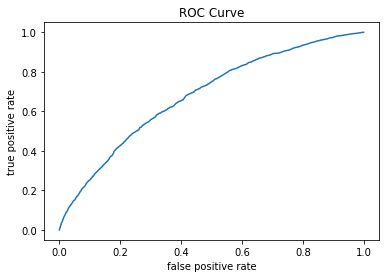

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

classifier  = xgb.fit(X_train_rus, y_train_rus)
scores = classifier.predict_proba(X_test.values)[:,1] #X_test'.VALUES' cause it somehow prevent test and training sets from a mismatch error
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores) # Area under the curve calculation for setting recall scoring
print("AUC of ROC Curve:", roc_auc) 

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show


The curve suggests that it's possible to achieve a 0.8 recall score with a 0.6 false positive rate, which could not be bad, depending on the financial institution allocation needs.

Plotting feature relevance in the model

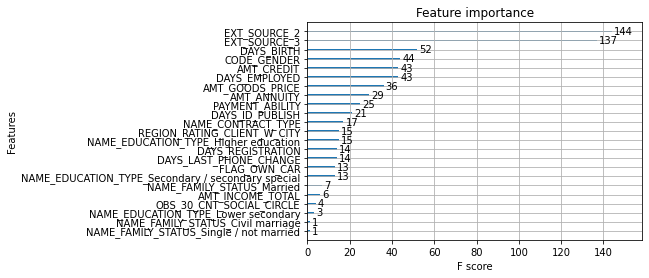

In [44]:
from xgboost import plot_importance
from matplotlib import pyplot
model = xgb
model.fit(X,y)
plot_importance(xgb)
pyplot.show()

CROSS VALIDATION

Model optimization by using GridSearchCV Function with Recall as Scoring Parameter (Seeks for its higher score choosing a value for the following parameters)

In [45]:
# n_estimators - The number of trees in the model
# max_depth - Maximum depth of a tree
# min_child_weight - Minimum sum of instance weight needed in a child
# gamma - Minimum loss reduction required to make a further partition on a leaf node of the tree
# learning_rate - Step size shrinkage used in the update to prevents overfitting

In [46]:
xgb = XGBClassifier()

# parameter to be searched
param_grid = {'n_estimators': range(0,1000,50)}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6757359821492838 for {'n_estimators': 600}


In [48]:
xgb = XGBClassifier(n_estimators=600)

# parameter to be searched
param_grid = {'max_depth': [1, 3, 5],
              'min_child_weight': [1, 3, 6]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6719930900453465 for {'max_depth': 3, 'min_child_weight': 1}


In [49]:
xgb = XGBClassifier(n_estimators=600, max_depth=3, min_child_weight=1)

# parameter to be searched
param_grid = {'gamma': [0, 1, 5]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6732167278485569 for {'gamma': 0}


In [50]:
xgb = XGBClassifier(n_estimators=600, max_depth=3, min_child_weight=1, gamma=0)

# parameter to be searched
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

# find the best parameter
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6706254948535233 for {'learning_rate': 0.1}


CONFUSION MATRIX
The main goal is to get the best Recall score without fully affecting the Precision score (avoid clasify any example as positive or '1')

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     54400
           1       0.16      0.67      0.26      4631

    accuracy                           0.70     59031
   macro avg       0.56      0.69      0.53     59031
weighted avg       0.90      0.70      0.77     59031



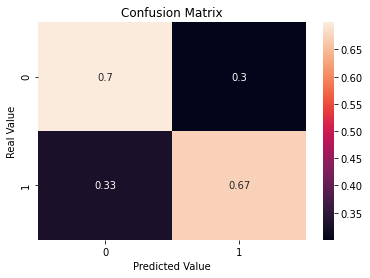

In [51]:
xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=600, gamma=0, min_child_weight=1)  # Newly optimized parameters
xgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

Evidently is needed to Improve the recall rate, the ROC curve suggest that it's possible to achieve a 0.8 recall score with Precison rate at 0.4, that performance could not be bad, depending on the financial institution allocation needs.